# ***Ebay Customer Reviews Cleaning Analysis ***

I used a data set from [kaggle.com ](https://www.kaggle.com/datasets/wojtekbonicki/ebay-reviews?select=ebay_reviews.csv) that contains information about product reviews on Ebay. Details about the columns and more information about the dataset is available on the provided link.
The data is uncleaned and unfiltered. In this project, I will be cleaning the data and extracting insights about product reviews through exploratory analysis. I will aim to answer the following questions: What is the most common rating given by cutomers? What is the average rating?

**Contents:**
1.   Cleaning
2.   Visualization
3. Analysis
4. Conclusion





In [ ]:
#installing the langdetect library for language detection
!pip install langdetect pandas

In [23]:
#Importing necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#loading in the csv file ebay_reviews
df = pd.read_csv('ebay_reviews.csv')
data = df #we will use both df and data to refer to the dataset
df.columns

Index(['category', 'review title', 'review content', 'rating'], dtype='object')

Details about the columns and descriptions available on Kaggle (on the link provided in the introduction)

In [ ]:
df

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5
...,...,...,...,...
44751,Racks & Holders,Utensil holder,Reasonably priced but a little flimsy,3
44752,Racks & Holders,Recommended,As described,5
44753,Racks & Holders,cheap looking,cheap looking,1
44754,Racks & Holders,Ok,Okay,5


In [ ]:
#finding columns with null values
df.isnull().any()

category          False
review title       True
review content    False
rating            False
dtype: bool

In [ ]:
#After finding that only review title has null values, we find the no. of null values in review title
if 'review title' in df.columns:
    null_count = df['review title'].isnull().sum()
    print(f"null_count: {null_count}")

null_count: 2


In [4]:
#identifying null rows
null_rows = df[df['review title'].isnull()]
print(null_rows)

                        category review title  \
11780        Clippers & Trimmers          NaN   
33236  Cell Phones & Smartphones          NaN   

                        review content  rating  
11780  Excellent.  Just what I needed.       5  
33236                        Awesome..       5  


In [5]:
#removing the null values
df.dropna(subset=['review title'], inplace=True)

In [ ]:
#checking nulls were removed
print(df.loc[11780:33236, 'review title'])

11781                           Great
11782                          thanks
11783                       Retracted
11784                           Great
11785                              A+
                     ...             
33231                     Great Phone
33232                      Great item
33233                           Great
33234                      Muy buenos
33235    All I can say thank you guys
Name: review title, Length: 21455, dtype: object


In [6]:
#removing duplicates
df.duplicated(subset=['review content'])
df.drop_duplicates

<bound method DataFrame.drop_duplicates of               category                                      review title  \
0             Headsets                          Wireless gaming headset    
1             Headsets        Good for those with a big head, low budget   
2             Headsets                     MezumiWireless Gaming Headset   
3             Headsets                             HW- S2 great headset.   
4             Headsets  BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE   
...                ...                                               ...   
44751  Racks & Holders                                    Utensil holder   
44752  Racks & Holders                                       Recommended   
44753  Racks & Holders                                     cheap looking   
44754  Racks & Holders                                                Ok   
44755  Racks & Holders                                  Cooking utensils   

                                          review content  rating  
0      This gaming headset ticks all the boxes # look...       5  
1      Easy setup, rated for 6 hours battery but mine...       3  
2      I originally bought this wireless headset for ...       5  
3      This is my 2nd Mezumi headset, It kills the fi...       5  
4      This is probably the best headset I've purchas...       5  
...                                                  ...     ...  
44751              Reasonably priced but a little flimsy       3  
44752                                       As described       5  
44753                                      cheap looking       1  
44754                                               Okay       5  
44755                                          Are goodg       4  

[44754 rows x 4 columns]>

I used classes and/or user-defined transformers based on a few methods that I found on kaggle, but **I wrote all the code on my own and made my own adjustments**. I used this method since it simplifies cleaning datasets with large amounts of data and has shorter run times. In the below cell, the class 'TextCleaner' is a transofrmer specifically used for cleaning Text data. I started with this step, because removing the factors listed below and cleaning the data facilitates vectorization and language detection.

In [7]:
#Intializing classes to unify the words to be lowercase, remove punctuation, symbols, and multiple spaces
#X refers to the input data/ dataset
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, pattern=r"[!?:;\"#'$%&()*+,-./<=>@[\\]^_`{|}~]"):#setting the symbols that I would like to remove
        self.pattern = pattern

    def fit(self, X, y=None): #no function, returns instance
        return self

    def transform(self, X):#transform is used for function application, removing symbols in this case
        X_cleaned = X.copy()#X_cleaned refers to the new cleaned, updated dataset and X.copy is simply a copy of the original data(X)

        # Replace multiple spaces with a single space
        X_cleaned.replace({"\s\s+":" "}, regex=False, inplace=True)#removes multiple spaces, puts a single space instead

        for col in X_cleaned.columns:
            if X_cleaned[col].dtype == object:  # Only process text columns
                X_cleaned.loc[:,col] = X_cleaned[col].str.replace(self.pattern, '', regex=True).str.lower()#transforming all upper case letters to lower case
        return X_cleaned


In [8]:
# Using TF-IDF for efficient vectorization. It allows us to separate words for easier analysis and filtering
# product reviews
reviews = df['review content']
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', lowercase=True) # We include 'stop_words', and specify the language as english, in order to filter the data further and remove unnecessary or unimportant words
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
tfidf_scores = tfidf_matrix.toarray()#multiplies Tf with IDF

#displaying the vectorized terms (feature names)
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['00', '000', '00001', ..., '可是我的东西不知道还在哪里', '收货的日子已经过去了', '索尼大法好'],
      dtype=object)

when printing the feature names, we find that there are some words in foreign languages in several rows. In the below cells, I use the class 'ForeignReviewsRemover' to remove any worda that are not in english.

In [9]:
class ForeignReviewsRemover (BaseEstimator, TransformerMixin):
    def __init__(self, see_dismissed=False):
      words = stopwords.words('english')#cleaning the data from common english stop words
      #words that may be important for sentiment analysis
      sentiment_words = ['good','beautiful', 'cheap', 'great','best','well','work','working','excellent','price','nice','handy','no','bad','terrible','worse','worst','broken','no','useless', 'ok','yes','fine','okay','awesome','awful', 'low', 'high', 'cool', 'recommend']
      words.extend(sentiment_words)
      self.words = words
      self.pattern = ""
      self.see_dismissed = see_dismissed

    def fit(self, X, y=None, user_words=[]):
      self.words.extend(user_words)
        #pattern for removing stop words
      self.pattern = " | ".join(self.words) + "| ".join(self.words) + " |".join(self.words)
      return self
    #applies pattern to clean the data and edit the cleaned dataset
    def transform(self, X):
      transformed_data = X.copy()
    def transform(self, X):
        X_cleaned = X.copy()

        X_temp = pd.DataFrame()
        cols_to_join = []

        for col in X_cleaned.columns:#converting datatypes
            if not X_cleaned.loc[:, col].dtypes == int:
                cols_to_join.append(col)
       #specifying the columns I want to join and converting them into strings and concatenating them with a ('') and assigns the columns to 'connected'
        #using the defined pattern in fit function
        X_temp['connected'] = X_cleaned[cols_to_join].astype(str).agg(' '.join, axis=1)#checking if 'connected' has a substring or pattern defined
        idx = np.where(X_temp['connected'].str.contains(self.pattern, case=False, regex=True).values == True, True, False)#boolean array that shows which rows from 'connected' contain the previously mentioned pattern

        if self.see_dismissed == True:
            for row in X_cleaned['connected'][~idx]:
                print(row)
        return X_cleaned[idx]

In [10]:
#The StopWordsRemover class removes common english stop words
class StopWordsRemover(BaseEstimator, TransformerMixin):
   def __init__(self, keep_words = ['many','few','not', 'off','all','any','never','no','extremely','very']):#excluding some words and keeping them in the dataset as they are useful for analysis
    stop_words = set(stopwords.words('english'))
    self.eng_words = stop_words.difference(set(keep_words))#excluding the 'keep_words'from the stop words
    words_to_remove={'read','full','review'}#redundant words that are present by default and appear too often, this was also evident after the first time I ran the code to generate the wordcloud figure(it didn't work)
    self.words = list(set(stop_words).difference(words_to_remove))

   def fit(self, X, y=None):
        return self

   def transform(self, X):
        X_cleaned = X.copy()

        for col in X_cleaned.columns:
            if X_cleaned.loc[:, col].dtypes == int: continue
            for en, review in enumerate(X_cleaned.loc[:, col].astype(str)):
                new = (" ").join(j for j in review.split(" ") if j.lower() not in self.eng_words)
                try:
                    X_cleaned.loc[:, col].iloc[en] = new
                except:
                    continue
        return X_cleaned


In [11]:
#The class Stemmer allows us to analyse root words and eliminates uneccessary parts of words like: -ed, or certain prefixes
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stem=True):
        self.stemmer = nltk.PorterStemmer()#instant initialization
        self.stem = stem

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not self.stem:
            return X
        else:
            X_cleaned = X.copy()
            for col in X_cleaned.columns:
                if X_cleaned.loc[:, col].dtypes == int:#skips integer containing columns
                  continue
                for en, review in enumerate(X_cleaned.loc[:, col].astype(str)):#transforms column data into strings
                    new = " ".join(self.stemmer.stem(word) for word in review.split(" "))#joins stemmed words into one string
                    try:
                        X_cleaned[:, col].iloc[en] = new
                    except:
                        continue
            return X_cleaned

In [12]:
# changing ratings to zeroes and ones to facilitate finding the best and worst
class Rating(BaseEstimator, TransformerMixin):
    def __init__(self, scale={1:1, 2:1, 3:0, 4:0, 5:0}, labels_to_del=[]):
        self.scale = scale
        self.labels_to_del = labels_to_del

    def fit(self, X, y=None):
        if self.labels_to_del != []: #ratings of 3 will be automatically removed
            self.idx_to_del = X['rating'] == self.labels_to_del[0]
        return self

    def transform(self, X):
        X_cleaned = X.copy()
        if self.labels_to_del:
            X_cleaned = X_cleaned[~self.idx_to_del]
        X_cleaned.replace(self.scale, inplace=True)
        return X_cleaned

In [13]:
#we create a pipeline in order to use the transformers we created for some machine learning approaches
#relisting the columns we're editing/cleaning
columns = ['review title', 'review content', 'rating']

#we use this pipeline to encapsulate the classes and to simplify running the code and using it for machine learning methods like Linear Regression
preprocessor = Pipeline([

    ('ForeignReviewsRemover',ForeignReviewsRemover()),

    ('StopWordsRemover',StopWordsRemover()),

    ('TextCleaner',TextCleaner()),

    ('Stemmer', Stemmer(stem=False)),
    # negative(1, 2) ratings = -1, neutral (3)= 0 and positive(4,5)=1
    ('Rating', Rating(scale={1:-1, 2:-1, 3:0, 4:1, 5:1})),
])

In [14]:
#we run preprocessor to run everything to see the full results
preprocessor.fit(data[columns])
data_preprocessed = preprocessor.transform(data[columns])

Streaming output truncated to the last 5000 lines.
<ipython-input-10-ec34ca195456>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cleaned.loc[:, col].iloc[en] = new
<ipython-input-10-ec34ca195456>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cleaned.loc[:, col].iloc[en] = new
<ipython-input-10-ec34ca195456>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cleaned.loc[:, col].iloc[en] = new
<ipython-input-10-ec34ca195456>

In [17]:
 df_clean = data_preprocessed
 df_clean

,review title,review content,rating
0,wireless gaming headset,gaming headset ticks all boxes # looks grate #...,1
1,"good big head, low budget","easy setup, rated 6 hours battery mine lasted ...",0
2,mezumiwireless gaming headset,originally bought wireless headset xbox (lates...,1
3,hw- s2 great headset.,"2nd mezumi headset, kills first one , better r...",1
4,best headphones i've purchased entire life,probably best headset i've purchased till date...,1
...,...,...,...
44751,utensil holder,reasonably priced little flimsy,0
44752,recommended,described,1
44753,cheap looking,cheap looking,-1
44754,ok,okay,1


The table above shows a preprocessed version of the dataset.
I tried to clean the data from symbols and punctuation several times, and I ran many different alterations of the code and tried completely different methods, but it did not work any time but I included the code in my project in order to demonstrate how to do it and to show that it is important in data cleaning


Text(0.5, 1.0, 'Distribution of Ratings')

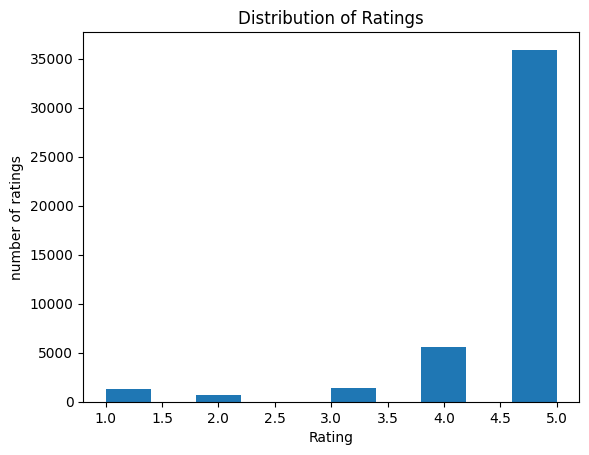

In [19]:
# Distribution of Ratings table
#divide bars to show different categories


plt.hist(df['rating'])
plt.xlabel('Rating')
plt.ylabel('number of ratings')
plt.title('Distribution of Ratings')

The above table shows the distribution of product ratings, and this graph clearly shows that the majority of customers gave positive reviews, with around 90% or more than 30,000 ratings being between 4.5 and 5.0.

In [ ]:
cosine_sim = cosine_similarity(tfidf_scores)

I was unable to excute this code because running it would take up all the RAM and cause the session to crash. I included it because when calculating, it can be a really useful metric to measure the simialrity between metrics

In [ ]:
# I calculated the average to find the mean rating that customers give and identify whether it's negative or positive
average_rating = df['rating'].mean()
print('average rating =', average_rating)

average rating = 4.656321222684006


The average rating of 4.656, and majority of ratings being positive shows that customers who leave reviews are generally satisifed with the products they receive.

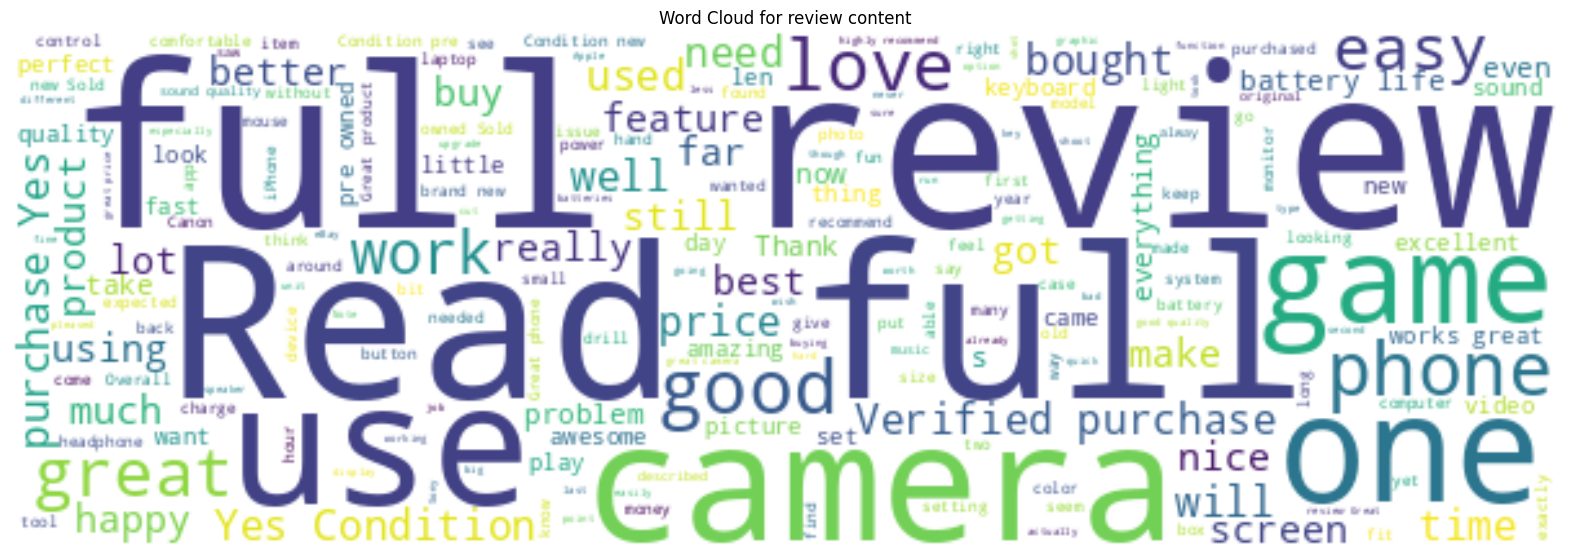

In [ ]:
txt_col = 'review content'  # Replace with an actual text column name
if txt_col in data.columns:
    txt_data = ' '.join(data[txt_col].dropna().astype(str))

    wordcloud = WordCloud(width=600, height=200, background_color='white').generate(txt_data)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {txt_col}')
    plt.show()

The words with the larger font in the Wordcloud figure above are the most common ones in the review content column, which also would mean that they are used by users the most. In this case, it appears that words from the default ebay website such as; full, Read, and review 'Read full review' appear to be the ones that occur the most, which makes sense. I tried to clean the dataset from these words as shown in the Stop Words Remover class section, but that did not work as is evident from the Wordcloud that is displayed above. However, it is also clear that the words camera, game and phone also appear often within the dataset, which indicates that these are products that buyers usually review.
For a better understanding of sentiment, we observe that the words 'good, great and love' also appear often within the dataset indicating that most reviews were given by customers who are satisfied with the products.

### #K-means clustering

<ipython-input-22-414e99c074ad>:14: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
<ipython-input-22-414e99c074ad>:14: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
<ipython-input-22-414e99c074ad>:14: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
<ipython-input-22-414e99c074ad>:14: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)
<ipython-input-22-414e99c074ad>:14: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(scaled_features)


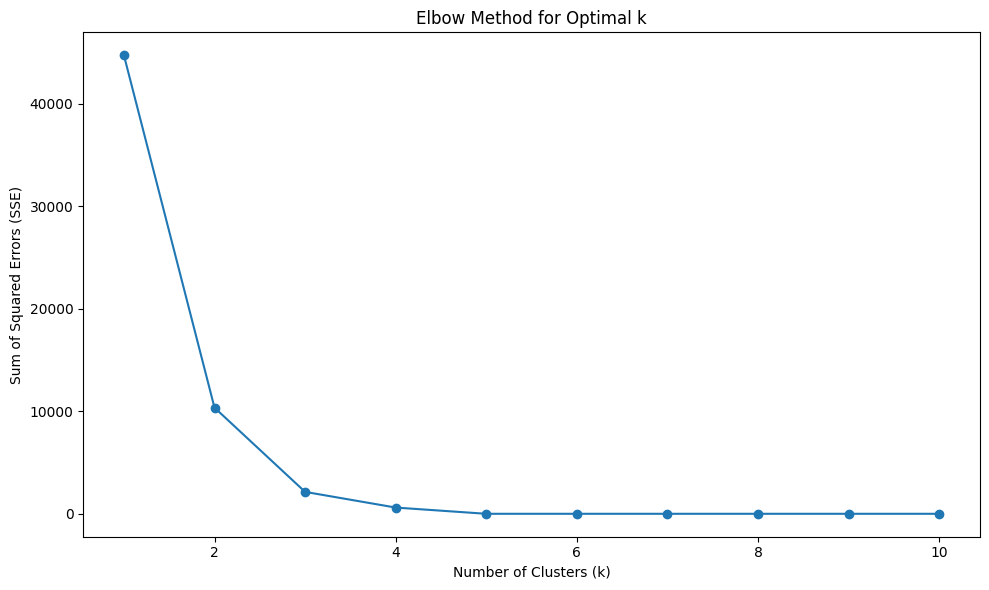

KeyError: 'Category'

<Figure size 1200x800 with 0 Axes>

In [22]:
# Preprocess data
numeric_features = df.select_dtypes(include=[np.number])

# Normalizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Determining the optimal number of clusters using the elbow method
sse = []
max_clusters = 10

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()

# Choose the no. of clusters by analyzing the elbow curve
optimal_clusters = 3

# Apply K-means with the chosen no. of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clean['Category'], df_clean['Rating'], c=df_clean['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Category')
plt.ylabel('Rating')
plt.title('K-means Clustering Results')
plt.tight_layout()
plt.show()

In [25]:

# Separate features and target
X = df.drop('Category', axis=1)
y = df['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(random_state=40, max_iter=100)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

# Generate and visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for LR Model')
plt.tight_layout()
plt.show()

KeyError: "['Category'] not found in axis"

We must perform encoding first in order to change the data types and make them appropriate for machine elarning model implementation but due to time and resource constraints this is what I can provide for now. We also need to keep adjusting values such as the number of iterations test_size and number of clusters in order to find the optimal values.


## **Conclusion**
After preprocessing the data, reviewing it, and performing using statistical techniques to better understand the dataset, it is evident based on the results of my preprocessing and analysis that positive reviews make up about 90% of the customer reviews and that customers usually leave reviews for electronic products such as phones or cameras. Customers also tend to leave more detailed reviews for these products.


**Recommendations:**

I suggest that the company creates new ways to incentivize customers to review other product categories that are not as popular and to leave more detailed reviews. For example, they can introduce a points system where customers can earn points and rewards when leaving reviews and give options for making reviews to facilitate the process, similar to the rating system.
